# ECU Floods

Notebook to compare flash flood risk in Ecuador

In [1]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats, gen_zonal_stats
from glob import glob
import matplotlib.pyplot as plt
import shapely

In [2]:
# open polys
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

In [3]:
#### Functions
def zone_loop(polys_in, rst_list, stats_type, col, split):
    """ Function loops through rasters, calcs zonal_stats and returns stats as a data frame.
    Args:
        polys_in = polygons
        rst_list = list of paths & fns of rasters
        stats_type = stats type for each poly gone (see zonal stats)
        col = column to merge it all
        split = where to split the file name string (e.g. _matched.tif)
    """
    
    # copy polys to write out
    polys_out = polys_in.copy()
    
    for rst in rst_list:
        
        # Get data name
        data = rst.split(DATA_PATH+'interim/')[1].split(split)[0]
        print('Started', data)
        
        # Run zonal stats
        zs_feats = zonal_stats(polys_in, rst, stats=stats_type, geojson_out=True)
        zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
        
        # Rename columns and merge
        zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
        
        polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')
    
    return polys_out

In [4]:
def poly_prep(polys_fn, col):
    "function opens earth quake polygons for zonal loop"
    
    # open
    polys = gpd.read_file(polys_fn)
    
    # subset, be sure to check the admin level
    polys = polys[['geometry', col]]
    
    return polys

In [5]:
def get_stats(df):
    "Get min, max, range, and pca flood risk columns from a df"
    
    # Find range
    df['max'] =df.iloc[:,2:7].max(axis = 1)
    df['min'] =df.iloc[:,2:7].min(axis = 1)
    df['range'] =df['max'] -df['min']
    
    # make PCA risk quintiles (1 - 5, worst to bes)
    df['risk'] = np.where(df['susc_PCA'] >= .6, 4, 1)
    df['risk'] = np.where(((df['susc_PCA'] >= .5) & (df['risk'] == 1)), 3,df['risk'])
    df['risk'] = np.where(((df['susc_PCA'] >= .4) & (df['risk'] == 1)), 2,df['risk'])
    
    return df

## Flood risk All

In [6]:
# Git tif files
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*all_Ecuador.tif'))
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_all_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GHS15_all_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_all_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_all_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_all_Ecuador.tif']

In [7]:
# Open flood susceptability layer
ecu_fn = DATA_PATH+'raw/ECU-Floods/Susceptibility/FF_suscept_PCA.shp'
col = 'susc_PCA'
ecu_all = poly_prep(ecu_fn, col)

In [8]:
# Need to reproject crs to epsg:4326
ecu_all = ecu_all.to_crs('epsg:4326')


In [9]:
# Run zonal stats loop
ecu_all_sum = zone_loop(ecu_all, rst_fns, 'sum', col, '_all_Ecuador.tif')

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


In [10]:
ecu_all_out = get_stats(ecu_all_sum)

In [11]:
# Save it out
fn_out = DATA_PATH+'interim/ECU-Flood-Risk_all.shp'
ecu_all_out.to_file(fn_out)

In [12]:
# check
pop_all = ecu_all_out['ESRI16_sum'].sum()

## Flood risk rural

In [13]:
# Git tif files
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*rural_Ecuador.tif'))
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_rural_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GHS15_rural_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_rural_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_rural_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_rural_Ecuador.tif']

In [14]:
# Run zonal stats loop
ecu_rural_sum = zone_loop(ecu_all, rst_fns, 'sum', col, '_rural_Ecuador.tif')

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


In [15]:
ecu_rural_out = get_stats(ecu_rural_sum)

In [16]:
# Save it out
fn_out = DATA_PATH+'interim/ECU-Flood-Risk_rural.shp'
ecu_rural_out.to_file(fn_out)

## Flood risk urban

In [17]:
# Git tif files
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*urban_Ecuador.tif'))
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_urban_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GHS15_urban_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_urban_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_urban_Ecuador.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_urban_Ecuador.tif']

In [18]:
# Run zonal stats loop
ecu_urban_sum = zone_loop(ecu_all, rst_fns, 'sum', col, '_urban_Ecuador.tif')

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


In [19]:
ecu_urban_out = get_stats(ecu_urban_sum)

In [20]:
# Save it out
fn_out = DATA_PATH+'interim/ECU-Flood-Risk_urban.shp'
ecu_urban_out.to_file(fn_out)

## Check Data

In [21]:
list(range(1,6))

[1, 2, 3, 4, 5]

In [22]:
col = 'ESRI16_sum'
df = ecu_all_out
count = 0
for num in list(range(1,6)):
    pop = df[df['risk'] == num][col].sum()
    print(pop/10**6)
    count = count + pop
print('final', count/10**6)

1.224001
6.786817
6.998478
2.856822
0.0
final 17.866118


In [23]:
col = 'ESRI16_sum'
df = ecu_rural_out
count = 0
for num in list(range(1,6)):
    pop = df[df['risk'] == num][col].sum()
    print(pop/10**6)
    count = count + pop
print('final', count/10**6)

0.791164
3.723643
4.653177
1.012755
0.0
final 10.180739


## Explore plots

In [81]:
def bar_plot(df, col, off_set, a_v, bar_color, scale, pattern = None):
    """ Make a custom bar plots
    Args: 
        df = data frame to plot
        col = name of col to plot
        off_set = off_set of bar as float
        a_v = alpha 
        bar_color = color as string
        hatch = type, default is none
    """
    
    # Plot
    data = df[df['risk'] == 1][col].sum()
    a = plt.bar(1+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = 'black',  hatch = pattern)
    data = df[df['risk'] == 2][col].sum()
    b = plt.bar(2+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = 'black',  hatch = pattern)
    data = df[df['risk'] == 3][col].sum()
    c = plt.bar(3+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = 'black',  hatch = pattern)
    data = df[df['risk'] == 4][col].sum()
    d = plt.bar(4+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = 'black',  hatch = pattern)

    return a,b,c,d

In [82]:
#### set colors
ESRI16_c = 'blue'
GHS15_c = 'indigo'
GPWv4_c = 'deeppink'
LS15_c = 'deepskyblue'
WP16_c = 'forestgreen'

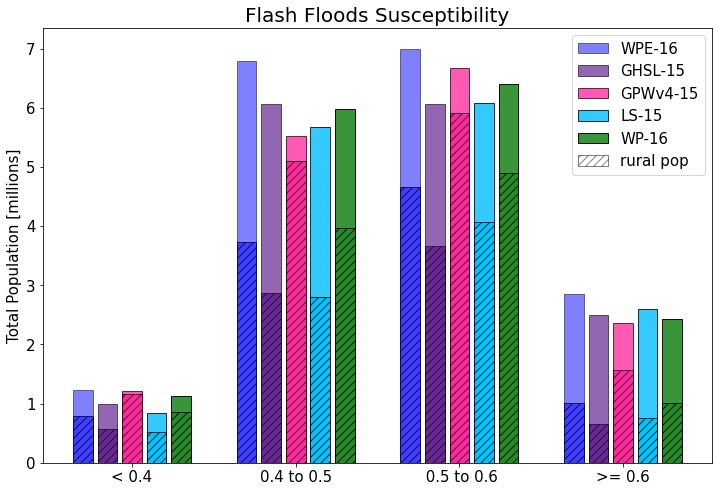

In [88]:
# Make bar plot 
fig, axs = plt.subplots(1, 1, figsize = (12, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale_data = 10**6

# Fake rural for legend
f = bar_plot(ecu_rural_out, 'ESRI16_sum', -0.3, 0.5, 'white',  scale_data, '///')

# All data
a = bar_plot(ecu_all_out, 'ESRI16_sum', -0.3, 0.5, ESRI16_c, scale_data, None)
b = bar_plot(ecu_all_out, 'GHS15_sum', -0.15, 0.6, GHS15_c, scale_data, None)
c = bar_plot(ecu_all_out, 'GPWv4_sum', 0, 0.7, GPWv4_c, scale_data, None)
d = bar_plot(ecu_all_out, 'LS15_sum', 0.15, 0.8, LS15_c, scale_data, None)
e = bar_plot(ecu_all_out, 'WP16_sum', 0.3, 0.9, WP16_c, scale_data, None)

# Rural
bar_plot(ecu_rural_out, 'ESRI16_sum', -0.3, 0.5, ESRI16_c,  scale_data, '///')
bar_plot(ecu_rural_out, 'GHS15_sum', -0.15,  0.6, GHS15_c,  scale_data, '///')
bar_plot(ecu_rural_out, 'GPWv4_sum', 0,  0.7, GPWv4_c,  scale_data,'///')
bar_plot(ecu_rural_out, 'LS15_sum', 0.15,  0.8, LS15_c, scale_data, '///')
bar_plot(ecu_rural_out, 'WP16_sum', 0.3,  0.9, WP16_c,  scale_data,'///')

# # Fake rural for legend
# f = bar_plot(ecu_rural_out, 'ESRI16_sum', -0.3,0.0, ESRI16_c,  scale_data, '///')

# tics
ticks_bar = ['< 0.4', '0.4 to 0.5', ' 0.5 to 0.6', '>= 0.6']
plt.xticks([1,2,3,4], ticks_bar, fontsize = 15)
plt.yticks(fontsize = 15)

leg = [a[0],b[0],c[0],d[0],e[0], f[0]]
leg_labels = ['WPE-16', 'GHSL-15', 'GPWv4-15', 'LS-15', 'WP-16', 'rural pop']
plt.legend(leg, leg_labels, fontsize = 15)

# Labels / Titles
axs.set_title('Flash Floods Susceptibility', size = 20)
axs.set_xlabel('', fontsize = 15)
axs.set_ylabel('Total Population [millions]', fontsize = 15)

# save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Fig5-ecu.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

### Risks out

In [105]:
# Save out by risk layer
r = 4
fn_out = DATA_PATH+'interim/ECU-Flood-Risk_all_r'+str(r)+'.shp'
out = ecu_all_out[ecu_all_out['risk']== r]
out.to_file(fn_out)